##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 画像セグメンテーション

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/segmentation.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">     Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このチュートリアルでは、修正した <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a> を使用した画像セグメンテーションのタスクに焦点を当てます。

## 画像セグメンテーションとは

画像分類タスクでは、ネットワークが各入力画像にラベル（またはクラス）を割り当てますが、そのオブジェクトの形状やどのピクセルがどのオブジェクトに属しているかなどを知りたい場合はどうすればよいでしょうか。この場合、画像のピクセルごとにクラスを割り当てようと考えるでしょう。このタスクはセグメンテーションとして知られています。セグメンテーションモデルは、画像に関してはるかに詳細な情報を返します。画像セグメンテーションには、医用イメージング、自動走行車、衛星撮像など、数多くの用途があります。

このチュートリアルでは [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)（Parkhi <em>et al</em>）を使用します。データセットには、37 種のペット品種と、品種当たり 200 枚の画像（train と test split で約 100 枚ずつ）が含まれます。それぞれの画像には対応するラベルとピクセル方向のマスクが含まれます。マスクは各ピクセルのクラスラベルです。各ピクセルには、次のいずれかのカテゴリが指定されます。

- クラス 1 : ペットに属するピクセル。
- クラス 2 : ペットと境界のピクセル。
- クラス 3: 上記のいずれにも該当しない、または周囲のピクセル。

In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to c:\users\nagat\appdata\local\temp\pip-req-build-ickagvkn
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git 'C:\Users\nagat\AppData\Local\Temp\pip-req-build-ickagvkn'


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
# tf のバージョンを確認
print(tf.__version__)

from tensorflow.python.client import device_lib

device_lib.list_local_devices()

2.10.1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14333782304339023083
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6263144448
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17531522383968315085
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:08:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [5]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import numpy as np
import glob


## Oxford-IIIT ペットデータセットをダウンロードする

データセットは [TensorFlow Datasets から入手できます](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet)。セグメンテーションマスクはバージョン 3 以上に含まれています。

In [6]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

また、画像の色値は `[0,1]` の範囲に正規化されています。最後に、上記で説明したとおり、セグメンテーションのマスクは {1, 2, 3} のいずれかでラベル付けされています。便宜上、セグメンテーションマスクから 1 を減算して、ラベルを {0, 1, 2} としましょう。

In [7]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [8]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [9]:
# 画像のラベル一覧
class_names = ['Holds',
               'Volume', 
               'Background',
               'Mat']

# 画像の色を定義
class_colors = [
    [255, 0, 0],
    [0, 128, 0],
    [0, 0, 255],
    [152, 251, 152]
]

os.getcwd()
input_file_path = os.getcwd() + '\images\workspace\input'
segment_file_path = os.getcwd() + '\images\workspace\segment'

input_file_list = glob.glob(input_file_path + '/*')
segment_file_list = glob.glob(segment_file_path + '/*')

# 画像を読み込む

データセットにはすでに必要となる training と test split が含まれているため、そのまま同じ split を使用します。

In [10]:
TRAIN_LENGTH = 1
BATCH_SIZE = 1
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

print(f"TRAIN_LENGTH: {TRAIN_LENGTH}"
      f"\nBATCH_SIZE: {BATCH_SIZE}"
      f"\nBUFFER_SIZE: {BUFFER_SIZE}"
      f"\nSTEPS_PER_EPOCH: {STEPS_PER_EPOCH}")

TRAIN_LENGTH: 1
BATCH_SIZE: 1
BUFFER_SIZE: 1000
STEPS_PER_EPOCH: 1


In [11]:

# train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
# test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# images ディレクトリにある画像を読み込む
# workspace が頭につくディレクトリに input, segment があるのでそれを読み込む


In [12]:
def load_input(file_path):
    # png を読み込む
    png_img = tf.io.read_file(file_path)
    input_image = tf.image.decode_png(png_img, channels=3)

    # 画像をリサイズ
    input_image = tf.image.resize(input_image, (128, 128))

    # 画像を正規化
    input_image = tf.cast(input_image, tf.float32) / 255.0

    return input_image


In [13]:
def load_segment(file_path):
    # png を numpyとして読み込む
    png_img = np.array(
        tf.image.decode_png(tf.io.read_file(file_path), channels=3))

    # 新しい形状の配列を初期化
    class_indices = np.zeros((png_img.shape[0], png_img.shape[1], 1), dtype=int)

    # 各クラスカラーに対してループ
    for index, color in enumerate(class_colors):
        # クラスカラーに一致するピクセルを検索し、インデックスで置換
        class_indices[(png_img == color).all(axis=-1)] = index

    # tf に変換
    class_indices = tf.convert_to_tensor(class_indices, dtype=tf.int8)

    # 画像をリサイズ
    class_indices = tf.image.resize(class_indices, (128, 128))

    # 画像を正規化
    class_indices = tf.cast(class_indices, tf.float32) / 255.0

    return class_indices


In [14]:
# 一度すべての画像を読み込んだあとテストとトレーニングに分ける
input_images = []
segment_images = []
for input_file, segment_file in zip(input_file_list, segment_file_list):
    input_images.append(load_input(input_file))
    segment_images.append(load_segment(segment_file))
    
print(f"input_images: {len(input_images)}"
      f"\nsegment_images: {len(segment_images)}")

train_image_size = int(len(input_images) * 0.5)
test_image_size = int(len(input_images) * 0.5)

# テストとトレーニングに分ける
train_images = input_images[:train_image_size]
test_images = input_images[train_image_size:]
train_segments = segment_images[:train_image_size]
test_segments = segment_images[train_image_size:]

# データセットに変換. 画像トラベルを一つにする
train_images = tf.data.Dataset.from_tensor_slices(
    (train_images, train_segments))
test_images = tf.data.Dataset.from_tensor_slices(
    (test_images, test_segments))
TRAIN_LENGTH = len(train_images)

print(f"TRAIN_LENGTH: {TRAIN_LENGTH}"
      f"\nBATCH_SIZE: {BATCH_SIZE}"
      f"\nBUFFER_SIZE: {BUFFER_SIZE}"
      f"\nSTEPS_PER_EPOCH: {STEPS_PER_EPOCH}")
print(f"\ntrain_images: {len(train_images)}"
      f"\ntest_images: {len(train_images)}")

input_images: 4
segment_images: 4
TRAIN_LENGTH: 2
BATCH_SIZE: 1
BUFFER_SIZE: 1000
STEPS_PER_EPOCH: 1

train_images: 2
test_images: 2


次のクラスは、画像をランダムにフリップする単純な拡張を実行します。詳細は、[画像のデータ拡張](data_augmentation.ipynb)チュートリアルをご覧ください。


In [15]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal",
                                                         seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal",
                                                         seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

入力パイプラインをビルドし、入力をバッチ処理した後に拡張を適用します。

In [16]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

画像サンプルと対応するデータセットのマスクを可視化しましょう。

In [17]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(128, 128, 1)


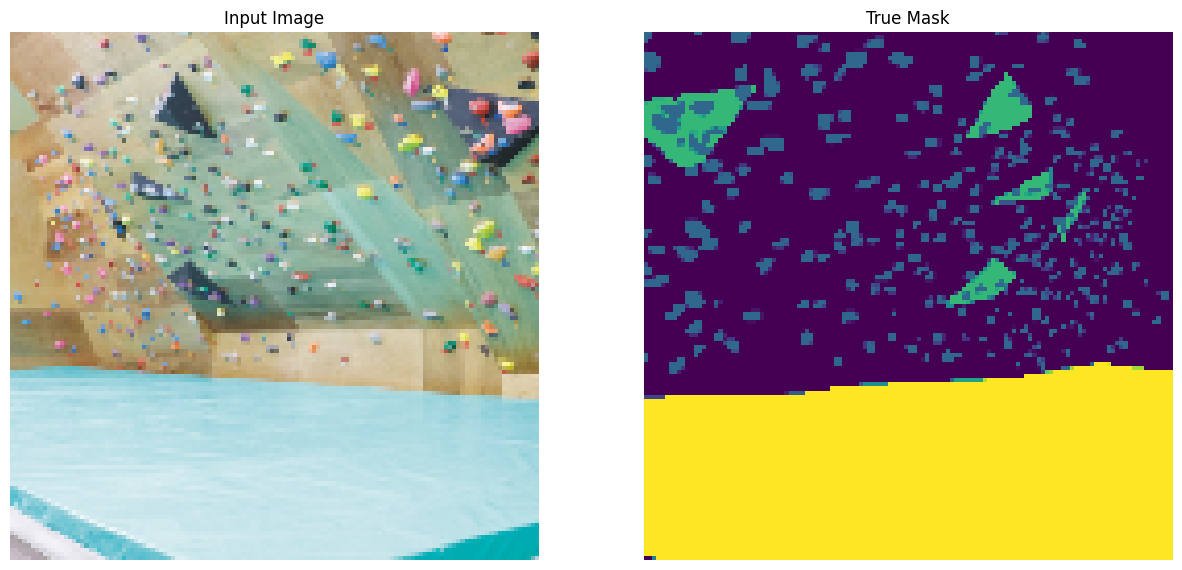

(128, 128, 1)


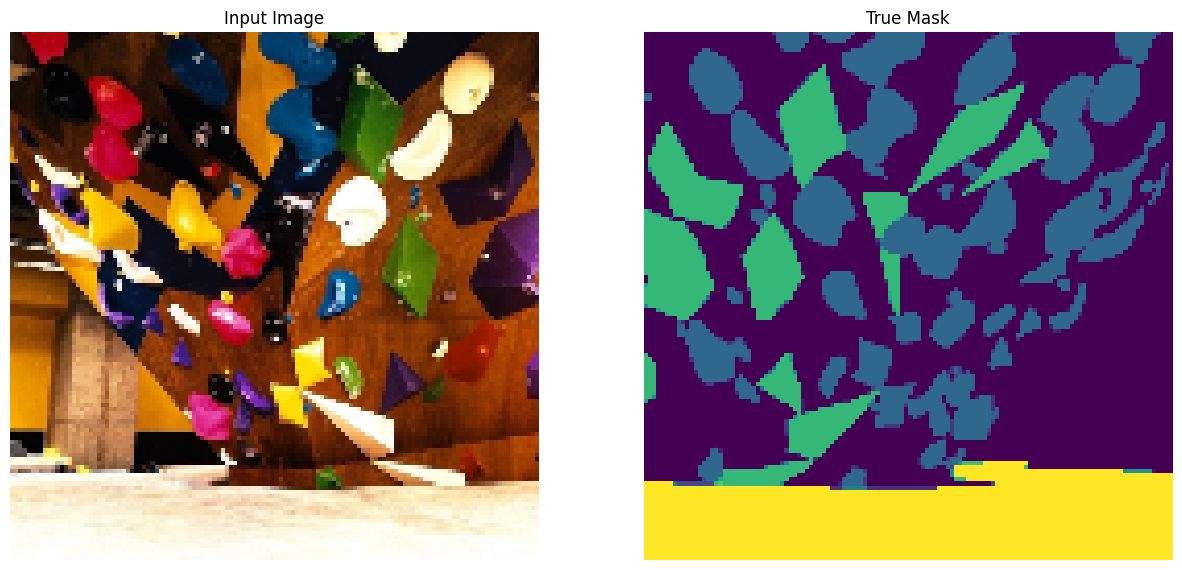

In [18]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    print(sample_mask.shape)

    display([sample_image, sample_mask])

## モデルを定義する

ここで使用されるモデルは修正された [U-Net](https://arxiv.org/abs/1505.04597) です。U-Net には、エンコーダ（ダウンサンプラー）とデコーダ（アップサンプラー）が含まれます。強力な特徴量を理解してトレーニング可能なパラメータ数を減らすため、MobileNetV2 というトレーニング済みモデルをエンコーダとして使用します。デコーダについてはアップサンプルブロックを使用しますが、これは TensorFlow Examples リポジトリの [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) の例に実装済みです。（ノートブックの [pix2pix: 条件付き GAN による画像から画像への変換](../generative/pix2pix.ipynb)チュートリアルをご覧ください。）


前述したように、エンコーダは事前トレーニング済み MobileNetV2 モデルであり、[tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications) で即座に使用できるように準備されています。エンコーダはモデル内の中間レイヤーからの特定の出力で構成されています。トレーニングプロセス中にエンコーダはトレーニングされないので注意してください。

In [19]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3],
                                               include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',  # 64x64
    'block_3_expand_relu',  # 32x32
    'block_6_expand_relu',  # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',  # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

デコーダおよびアップサンプラは、単に TensorFlow の 例に実装されている一連のアップサンプラブロックに過ぎません。

In [20]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),  # 32x32 -> 64x64
]

In [21]:
def unet_model(output_channels: int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

最後のレイヤーのフィルタ数は `output_channels` の数に設定されています。これはクラス当たり 1 つの出力チャンネルとなります。

## モデルをトレーニングする

では、後は、モデルををコンパイルしてトレーニングするだけです。

これはマルチクラスの分類問題であり、ラベルがクラスごとのピクセルのスコアのベクトルではなくスカラー整数であるため、`tf.keras.losses.CategoricalCrossentropy` 損失関数を使用して、`from_logits` を `True` に設定します。

推論を実行すると、ピクセルに割り当てられたラベルが最も高い値を持つチャンネルです。これは、`create_mask` 関数の作用です。

In [22]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

結果のモデルアーキテクチャを簡単に見てみましょう。

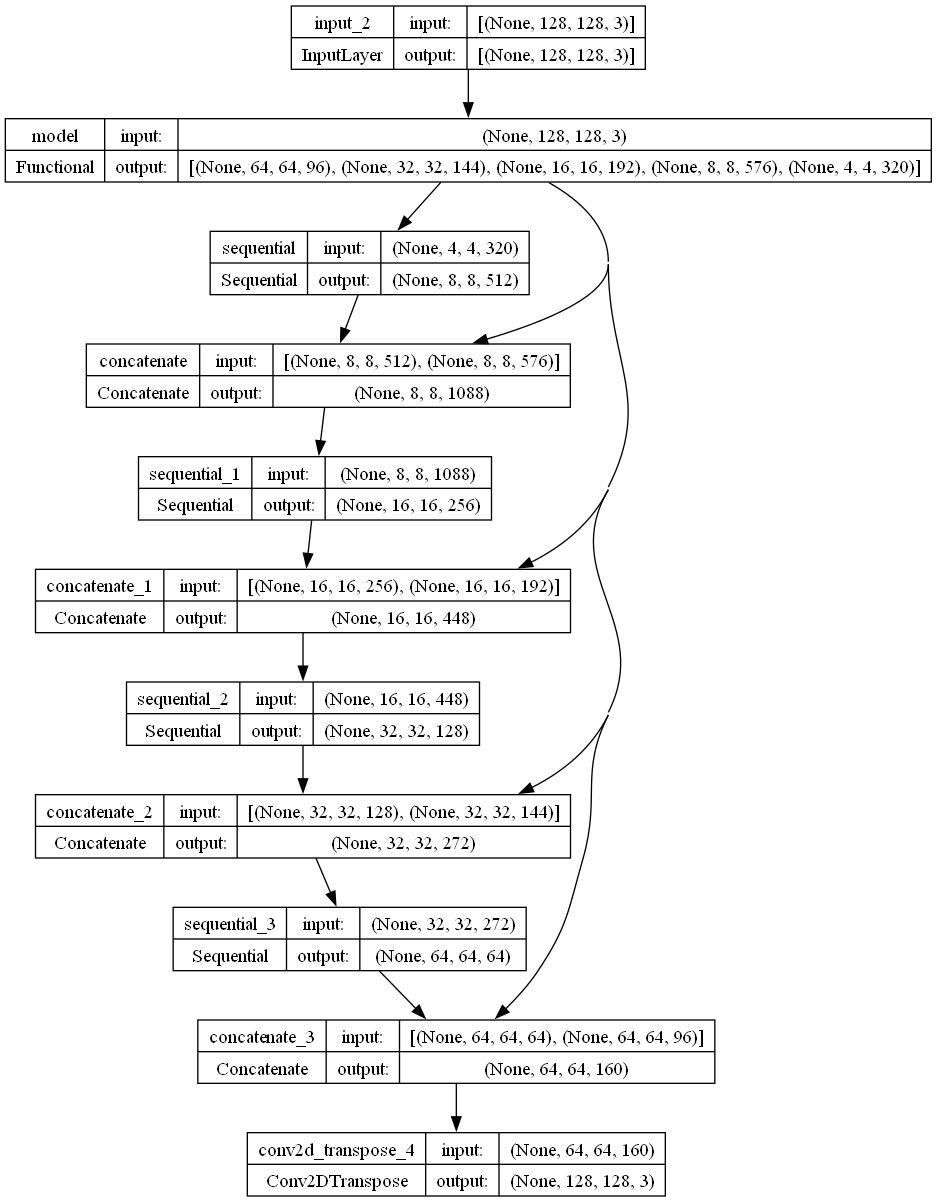

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

トレーニングする前に、モデルが何を予測するかを試してみましょう。

In [24]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [25]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 3s 3s/step


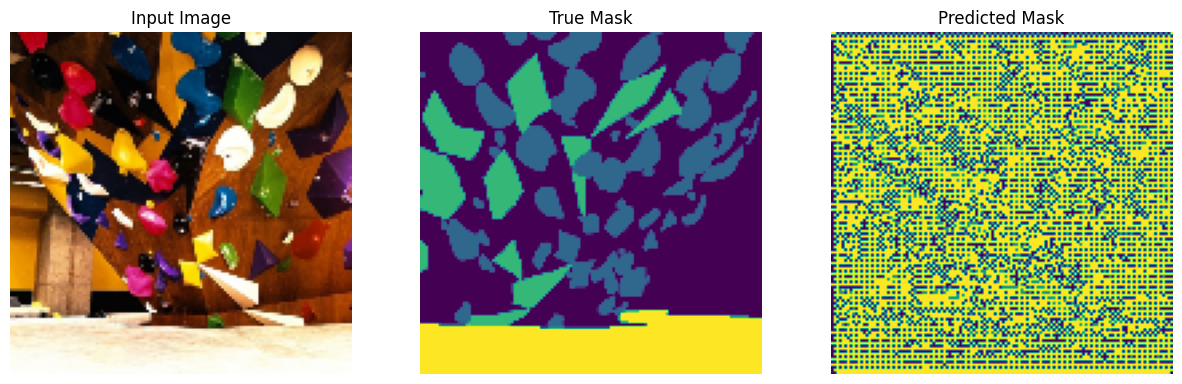

In [26]:
show_predictions()

以下に定義されるコールバックは、トレーニング中にモデルがどのように改善するかを観測するために使用されます。

In [27]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch + 1))

In [32]:
EPOCHS = 10
VAL_SUBSPLITS = 1
VALIDATION_STEPS = len(test_images) // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_batches,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

Epoch 1/10
1/1 [==============================] - 0s 51ms/step - loss: 0.0052 - accuracy: 0.4966 - val_loss: 0.0021 - val_accuracy: 0.7577
Epoch 2/10
1/1 [==============================] - 0s 50ms/step - loss: 0.0053 - accuracy: 0.5304 - val_loss: 0.0019 - val_accuracy: 0.7577
Epoch 3/10
1/1 [==============================] - 0s 54ms/step - loss: 0.0042 - accuracy: 0.4966 - val_loss: 0.0018 - val_accuracy: 0.7577
Epoch 4/10
1/1 [==============================] - 0s 52ms/step - loss: 0.0044 - accuracy: 0.5304 - val_loss: 0.0016 - val_accuracy: 0.7577
Epoch 5/10
1/1 [==============================] - 0s 53ms/step - loss: 0.0040 - accuracy: 0.5304 - val_loss: 0.0015 - val_accuracy: 0.7577
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.0033 - accuracy: 0.4966 - val_loss: 0.0014 - val_accuracy: 0.7577
Epoch 7/10
1/1 [==============================] - 0s 54ms/step - loss: 0.0030 - accuracy: 0.4966 - val_loss: 0.0013 - val_accuracy: 0.7577
Epoch 8/10
1/1 [===========

loss: [0.0052112555131316185, 0.005312155932188034, 0.00422001862898469, 0.004389998968690634, 0.004033003002405167, 0.0032514173071831465, 0.0030183587223291397, 0.0032407832331955433, 0.002642907900735736, 0.0028729094192385674]
val_loss: [0.0021226704120635986, 0.0019056964665651321, 0.0017505455762147903, 0.001606446923688054, 0.0014882669784128666, 0.0014059285167604685, 0.0013376633869484067, 0.0012676873011514544, 0.0012212840374559164, 0.001170889474451542]


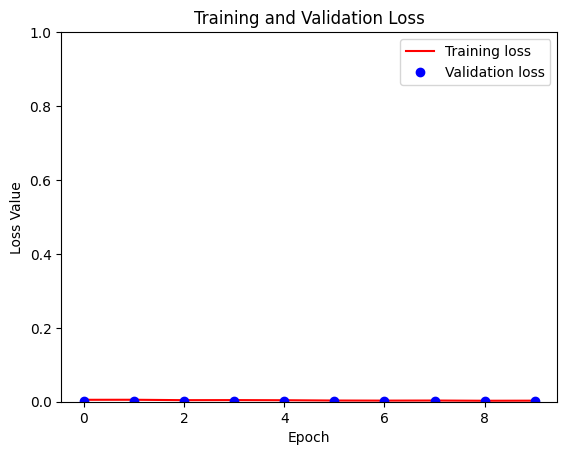

In [33]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
print(f"loss: {loss}\nval_loss: {val_loss}")

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## 予測する

いくつか予測を行ってみましょう。時間の節約重視の場合はエポック数を少なくしますが、高精度の結果重視の場合はエポック数を増やして設定します。

1/1 [==============================] - 0s 28ms/step


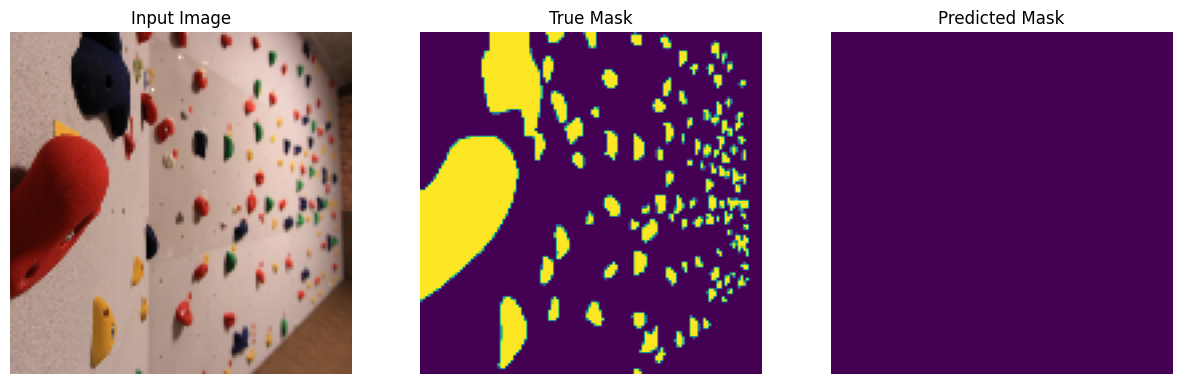

1/1 [==============================] - 0s 28ms/step


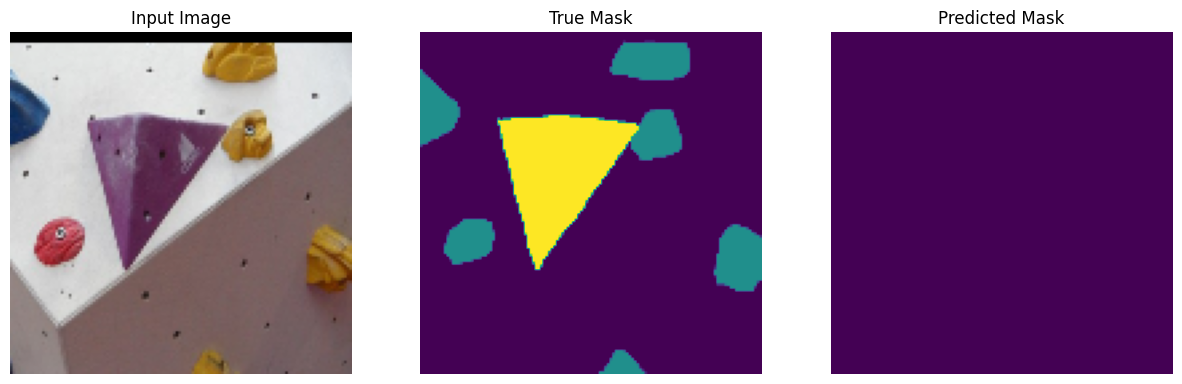

In [56]:
show_predictions(test_batches, 3)

## オプション: 不均衡なクラスとクラスの重み

セマンティックセグメンテーションデータセットは非常に不均衡であり、特定のクラスピクセルが他のクラスに比べて画像の内側寄りに存在する可能性があります。セグメンテーションの問題はピクセル単位の分類問題として対応することができるため、不均衡性を考慮して損失関数を重み付けすることで、不均衡の問題に対処することができます。単純かつエレガントにこの問題に取り組むことができます。詳細は、[不均衡なデータでの分類](../structured_data/imbalanced_data.ipynb)のチュートリアルをご覧ください。

[あいまいさを回避](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748)するために、`Model.fit` は 3 次元以上の入力の `class_weight` 引数をサポートしていません。

In [ ]:
try:
    model_history = model.fit(train_batches, epochs=EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              class_weight={0: 2.0, 1: 2.0, 2: 1.0})
    assert False
except Exception as e:
    print(f"Expected {type(e).__name__}: {e}")

そのため、この場合、自分で重み付けを実装する必要があります。これにはサンプルの重み付けを使用します。`Model.fit` は `(data, label)` ペアのほかに `(data, label, sample_weight)` トリプレットも受け入れます。

`Model.fit` は `sample_weight` を損失とメトリクスに伝搬しますが、`sample_weight` 引数も受け入れます。サンプル重みは、縮小ステップの前にサンプル値で乗算されます。次に例を示します。

In [ ]:
label = [0, 0]
prediction = [[-3., 0], [-3, 0]]
sample_weight = [1, 10]

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

つまり、このチュートリアルのサンプル重みを作るには、`(data, label)` ペアを取って `(data, label, sample_weight)` トリプルを返す関数が必要となります。`sample_weight` は各ピクセルのクラス重みを含む 1-channel の画像です。

実装を可能な限り単純にするために、ラベルを`class_weight` リストのインデックスとして使用します。

In [ ]:
def add_sample_weights(image, label):
    # The weights for each class, with the constraint that:
    #     sum(class_weights) == 1.0
    class_weights = tf.constant([2.0, 2.0, 1.0])
    class_weights = class_weights / tf.reduce_sum(class_weights)

    # Create an image of `sample_weights` by using the label at each pixel as an 
    # index into the `class weights` .
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights

この結果、データセットの各要素には、3 つの画像が含まれます。

In [ ]:
train_batches.map(add_sample_weights).element_spec

これで、この重み付けが付けられたデータセットでモデルをトレーニングできるようになりました。

In [ ]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

## 次のステップ

これで画像セグメンテーションとは何か、それがどのように機能するかについての知識が得られたはずです。このチュートリアルは、異なる中間レイヤー出力や、異なる事前トレーニング済みモデルでも試すことができます。また、Kaggle がホストしている [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) 画像マスキングチャレンジに挑戦してみることもお勧めです。

[Tensorflow Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/README.md) を参照して、独自のデータで再トレーニング可能な別のモデルを確認するのも良いでしょう。トレーニング済みのモデルは、[TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/tf2_object_detection#optional) にあります。